# Bubble Heatmap Tutorial

This notebook shows you how to visualize your results as a bubble heatmap, as in our paper.

We assume that your data file is in the format specified in the `README.md`,

... and that you've generated clustering results using our `clustr` package. This generates a 2-column `.tsv` file containing the columns `patient_id` and `cluster`, specifying the patient/participant identifier (this can be a random index) and the allocated cluster, respectively. We use one of the output files generated from running `tutorial.ipynb`.

In [1]:
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Load in the results folders, designated in constants:
from clustr.constants import HIER_AGG_RESULTS, KMEDOIDS_RESULTS, KMODES_RESULTS, LCA_RESULTS

from clustr.utils import get_arfs_prevalences, get_fischers_coefficients, get_bubble_heatmap_input

In [2]:
# get the data containing the conditions per participant
mmorb_df = pd.read_csv('./data/dummy_data.tsv', sep='\t', index_col=0)

In [3]:
mmorb_df.head(5)

,disease_1,disease_2,disease_3,disease_4,disease_5,disease_6,disease_7,disease_8,disease_9,disease_10,disease_11,disease_12,disease_13,disease_14,disease_15,disease_16,disease_17,disease_18,disease_19,disease_20
index,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0
3,0,1,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,0,0,1
4,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0
5,0,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,0,0,0


In [4]:
# get the cluster assignments
kmodes_df = pd.read_csv(osp.join(KMODES_RESULTS, 'run_1/kmodes_cluster_labels.tsv'), sep='\t', index_col=0)

In [5]:
kmodes_df.head(5)

,cluster
patient_id,
9954,3
3851,2
4963,1
3887,5
5438,3


In [6]:
# merge the dataframes, dropping indices in mmorb_df that are not in cluster assignment df
merged_df = mmorb_df.merge(kmodes_df, left_index=True, right_index=True)

In [7]:
merged_df.head(5)

,disease_1,disease_2,disease_3,disease_4,disease_5,disease_6,disease_7,disease_8,disease_9,disease_10,...,disease_12,disease_13,disease_14,disease_15,disease_16,disease_17,disease_18,disease_19,disease_20,cluster
131,0,1,1,1,1,1,0,1,1,0,...,1,1,1,0,0,0,1,0,0,6
219,1,0,1,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,2
223,1,1,1,0,0,0,0,1,0,1,...,0,1,1,1,0,0,0,1,0,6
255,1,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,3
287,0,0,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,1,0,1,5


# Adjusted Relative Frequency

Next, we compute the adjusted relative frequencies, or ARFs, as presented in our paper. 

Additionally, we compute the prevalences for each condition, relative to the rest of the cluster.

ARFs are computed for each condition per cluster, and can be understood as the ratio of the cluster prevalence to the cohort prevalence:

$$
\text{adjusted relative frequency (ARF)} = \frac{\text{\% participants with condition in cluster}}{\text{\% participants with condition in whole cohort}}
$$

In [8]:
arf_dict, prevs_dict = get_arfs_prevalences(df=merged_df,
                                            conditions=merged_df.columns[0:-1],
                                            labels_column='cluster')

## Fisher's Exact Test for Significance

As in our paper, we also perform [Fisher's Exact Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html) for differential representation. This generates two dictionaries: one with p-values, and another with Bonferroni-corrected *p*-values which adjust for [alpha inflation / FWER](https://en.wikipedia.org/wiki/Family-wise_error_rate).

In [9]:
coeffs, adj_coeffs = get_fischers_coefficients(df=merged_df,
                                   labels_column='cluster',
                                   conditions=merged_df.columns[0:-1],
                                   alpha=0.05)

The funny thing is, our dummy file was generated randomly, so we shouldn't see much significance. Let's corrupt the adjusted p-values to make visualization more fun.

**Don't do this in your study!!**

In [10]:
# NOTE: READ WARNING ABOVE- DON'T USE THIS FOR YOUR WORK!
for key, val in adj_coeffs.items():
    for condition, pval in val.items():
        adj_coeffs[key][condition] = np.random.uniform(0, 0.6)

## Bubble Heatmaps

Let's visualize those ARFs.

The package has a nice little function to prepare your data now.

- The first parameter is the values to plot, the second is the dictionary of p-values.
- The third parameter specifies that we wish to omit insignificant values with pval >= alpha (0.05, here). Pass 1 if you don't want any values omitted.
- Finally, the fourth parameter specifies whether values should be scaled for visualization purposes.

In [11]:
plot_input = get_bubble_heatmap_input(values_dict=arf_dict,
                                      pvalue_dict=adj_coeffs,
                                      alpha=0.05,
                                      arf_scaling=True
                                      )

Let's break down what this creates:

- `values` is the scaled ARF value (if scaling was applied).
- `abs_values` is the absolute value of the values column, so that we get the overall magnitude
- the sign was stored as a binary indicator in the `overrep` column. 1 indicates over-representation, while 0 is under.

Missing values indicate no statistical singificance.

In [12]:
plot_input.head(5)

,condition,cluster,values,abs_values,overrep
0,disease_12,6,0.476190,0.476190,1
1,disease_11,6,0.437500,0.437500,1
2,disease_13,6,0.328358,0.328358,1
3,disease_3,6,0.328358,0.328358,1
4,disease_14,6,0.148760,0.148760,1


From here, we can use a seaborn scatterplot to make the plot:

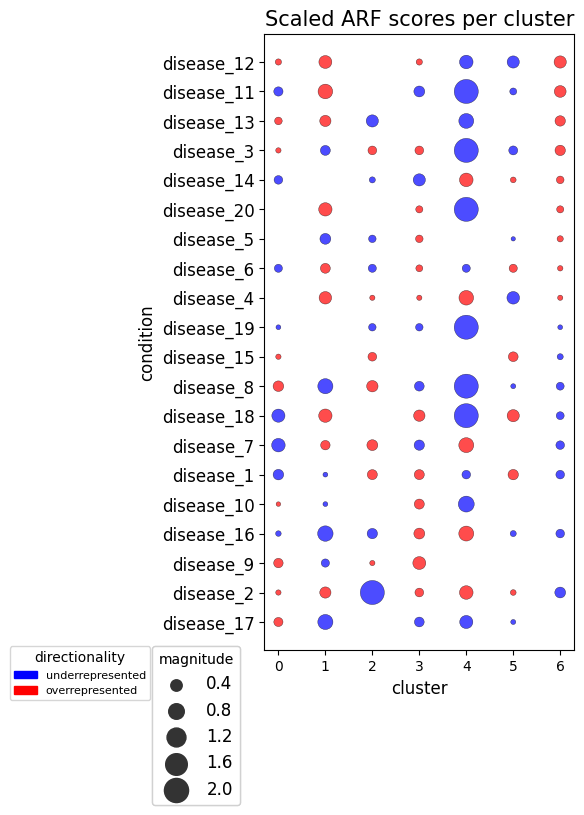

In [13]:
plt.figure(figsize=(4, 8))

sns.scatterplot(data=plot_input, x='cluster', y='condition', size='abs_values', sizes=(10, 300), alpha=0.7, hue='overrep', edgecolor='black', palette=['blue', 'red'])

# Add labels and a legend
plt.xlabel("cluster", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("condition", fontsize=12)
plt.title("Scaled ARF scores per cluster", fontsize=15)

# Legend code
color_legend = [Patch(color='blue', label='underrepresented'),
                Patch(color='red', label='overrepresented')]
legend1 = plt.legend(handles=color_legend, title="directionality", markerscale=0.5,
                     fontsize=8, bbox_to_anchor=(-0.35, .015))
handles, labels = plt.gca().get_legend_handles_labels()
legend2 = plt.legend(handles[4:], labels[4:], title="magnitude", bbox_to_anchor=(-0.05, .02), prop={'size': 12})  # Skip the first handle (hue) in the legend
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.show()

Want to add gridlines?

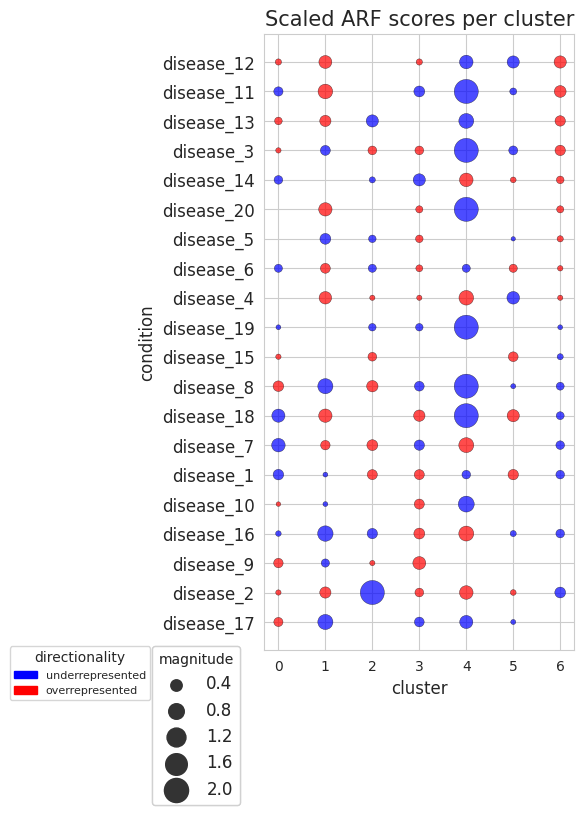

In [14]:
# Add gridlines
sns.set_style('whitegrid')

plt.figure(figsize=(4, 8))

sns.scatterplot(data=plot_input, x='cluster', y='condition', size='abs_values', sizes=(10, 300), alpha=0.7, hue='overrep', edgecolor='black', palette=['blue', 'red'])

# Add labels and a legend
plt.xlabel("cluster", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("condition", fontsize=12)
plt.title("Scaled ARF scores per cluster", fontsize=15)

# Legend code
color_legend = [Patch(color='blue', label='underrepresented'),
                Patch(color='red', label='overrepresented')]
legend1 = plt.legend(handles=color_legend, title="directionality", markerscale=0.5,
                     fontsize=8, bbox_to_anchor=(-0.35, .015))
handles, labels = plt.gca().get_legend_handles_labels()
legend2 = plt.legend(handles[4:], labels[4:], title="magnitude", bbox_to_anchor=(-0.05, .02), prop={'size': 12})  # Skip the first handle (hue) in the legend
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.show()

We can also add lines in the plot to show better separation between certain groups of clusters, if you want.

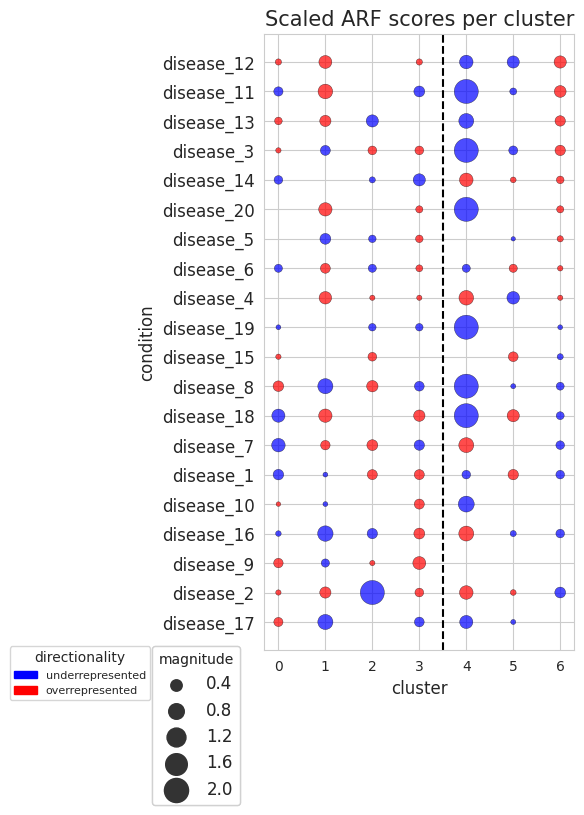

In [15]:
# Add gridlines
sns.set_style('whitegrid')

plt.figure(figsize=(4, 8))

sns.scatterplot(data=plot_input, x='cluster', y='condition', size='abs_values', sizes=(10, 300), alpha=0.7, hue='overrep', edgecolor='black', palette=['blue', 'red'])

# Add labels and a legend
plt.xlabel("cluster", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("condition", fontsize=12)
plt.title("Scaled ARF scores per cluster", fontsize=15)

# Legend code
color_legend = [Patch(color='blue', label='underrepresented'),
                Patch(color='red', label='overrepresented')]
legend1 = plt.legend(handles=color_legend, title="directionality", markerscale=0.5,
                     fontsize=8, bbox_to_anchor=(-0.35, .015))
handles, labels = plt.gca().get_legend_handles_labels()
legend2 = plt.legend(handles[4:], labels[4:], title="magnitude", bbox_to_anchor=(-0.05, .02), prop={'size': 12})  # Skip the first handle (hue) in the legend
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

# Add a line
plt.axvline(x=3.5, color='black', linestyle='--')

plt.show()

You can also specify a different order, if you want.

Let's say we want to order the diseases.

In [16]:
plot_input['condition_num'] = plot_input['condition'].apply(lambda x: int(x.split('_')[1]))
plot_input = plot_input.sort_values(by='condition_num')

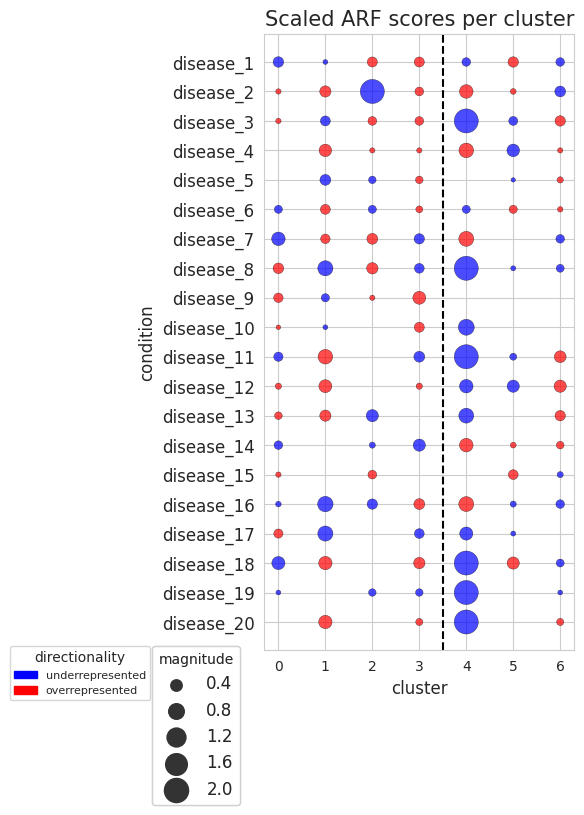

In [17]:
# Add gridlines
sns.set_style('whitegrid')

plt.figure(figsize=(4, 8))

sns.scatterplot(data=plot_input, x='cluster', y='condition', size='abs_values', sizes=(10, 300), alpha=0.7, hue='overrep', edgecolor='black', palette=['blue', 'red'])

# Add labels and a legend
plt.xlabel("cluster", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("condition", fontsize=12)
plt.title("Scaled ARF scores per cluster", fontsize=15)

# Legend code
color_legend = [Patch(color='blue', label='underrepresented'),
                Patch(color='red', label='overrepresented')]
legend1 = plt.legend(handles=color_legend, title="directionality", markerscale=0.5,
                     fontsize=8, bbox_to_anchor=(-0.35, .015))
handles, labels = plt.gca().get_legend_handles_labels()
legend2 = plt.legend(handles[4:], labels[4:], title="magnitude", bbox_to_anchor=(-0.05, .02), prop={'size': 12})  # Skip the first handle (hue) in the legend
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

# Add a line
plt.axvline(x=3.5, color='black', linestyle='--')

plt.show()

There you go - use `matplotlib.pyplot` and `seaborn` to alter your plot.

## Prevalences

We can also plot the prevalences if we want to compare. 

It's better to use a gradient color scheme for this, since there is no directionality here.

We'll also pass 1 for `alpha`, so as not to omit any values, and False for `arf_scaling` since they are not ARF values.

In [18]:
plot_input = get_bubble_heatmap_input(values_dict=prevs_dict,
                                      pvalue_dict=adj_coeffs,
                                      alpha=1,
                                      arf_scaling=False
                                      )

In [19]:
plot_input.head(5)

,condition,cluster,values,abs_values,overrep
0,disease_11,6,0.750,0.750,1
1,disease_3,6,0.750,0.750,1
2,disease_13,6,0.750,0.750,1
3,disease_12,6,0.750,0.750,1
4,disease_5,6,0.625,0.625,1


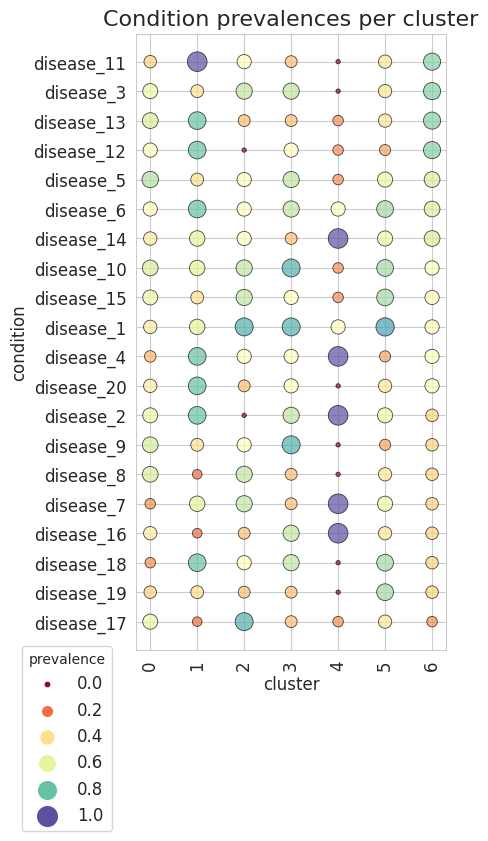

In [20]:
# Add gridlines
sns.set_style('whitegrid')

plt.figure(figsize=(4, 8))

scatter = sns.scatterplot(data=plot_input, x='cluster', y='condition', size='values', hue='values',
                sizes=(10, 200), alpha=0.7, edgecolor='black', palette='Spectral')

# Add labels and a legend
plt.xlabel("cluster", fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("condition", fontsize=12)

plt.title("Condition prevalences per cluster", fontsize=16)

plt.legend(title="prevalence", bbox_to_anchor=(-0.05, .02), prop={'size': 12})

plt.show()